train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df_sample =  pd.read_csv('test.csv')

In [3]:
column_alias = {
    'PassengerId': 'id', 'HomePlanet': 'home', 'CryoSleep': 'is_cryo', 'Cabin': 'cab', 'Destination': 'dest', 
    'Age': 'age',
    'VIP': 'vip', 'RoomService': 'has_room', 'FoodCourt': 'has_food', 'ShoppingMall':'has_shop',
    'Spa': 'has_spa', 'VRDeck': 'has_vrd',
    'Name': 'name', 'Transported': 'target'
}
decks = {'A': 1, 'B': 2, 'C':3, 'D':4,'E':5, 'F':6, 'G':7, 'T':8}
sides = {'P':0, 'S':1}

def count_relatives(x):
    return df[df['family'] == x].shape[0]

def by_relatives(x, key):
    try:
        res = df[(df['family']==x)&(~pd.isna(df[key]))][key].values[0]
        return res
    except IndexError:
        return np.nan
    
def set_total(row):
    all_nan = True
    
    total = 0
    for key in ['has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd']:
        if not pd.isna(row[key]):
            total += row[key]
            all_nan = False    
    return total if not all_nan else np.nan 

def resolve_cab(row):
    x = row['cab']
    if isinstance(x, str) and x.find('/') != -1 and len(x.split('/')) == 3:
        res = x.split('/')
        deck, num, side = decks.get(res[0]), int(res[1]), sides.get(res[2])
        return  deck, num, side
    else:
        return None, None, None  

In [4]:
# Переименование столбцов
df = df.rename(columns=column_alias)
df_sample = df_sample.rename(columns=column_alias)

In [5]:
df.isnull().sum()

id            0
home        201
is_cryo     217
cab         199
dest        182
age         179
vip         203
has_room    181
has_food    183
has_shop    208
has_spa     183
has_vrd     188
name        200
target        0
dtype: int64

In [6]:
df_sample.isnull().sum()

id            0
home         87
is_cryo      93
cab         100
dest         92
age          91
vip          93
has_room     82
has_food    106
has_shop     98
has_spa     101
has_vrd      80
name         94
dtype: int64

In [7]:
# Преобразование target к целому из логического
df = df.astype({'target': 'int32'})
# Выделение идентификатора семьи 
df['family'] = df['id'].apply(lambda x: x.split('_')[0])
df_sample['family'] = df_sample['id'].apply(lambda x: x.split('_')[0])
# количество родственников у пассажира 
#(это было надо чтоб посмотреть как семьи с разным количеством членов занимают каюты) 
df['family_size'] = df['family'].apply(lambda x: count_relatives(x))
df_sample['family_size'] = df_sample['family'].apply(lambda x: count_relatives(x))
# Заполнение пропущенных кают на каюты родственников
df['cab'] = df.loc[:,['cab', 'family']].apply(lambda x: by_relatives(x[1], 'cab') if pd.isna(x[0]) else x[0], axis=1)
df_sample['cab'] = df_sample.loc[:,['cab', 'family']].apply(lambda x: by_relatives(x[1], 'cab') if pd.isna(x[0]) else x[0], axis=1)

# Заполним пропущенные Home и Destination по родственникам
df['home'] = df.loc[:,['home', 'family']].apply(lambda x: by_relatives(x[1], 'home') if pd.isna(x[0]) else x[0], axis=1)
df['dest'] = df.loc[:,['dest', 'family']].apply(lambda x: by_relatives(x[1], 'dest') if pd.isna(x[0]) else x[0], axis=1)

df_sample['home'] = df_sample.loc[:,['home', 'family']].apply(lambda x: by_relatives(x[1], 'home') if pd.isna(x[0]) else x[0], axis=1)
df_sample['dest'] = df_sample.loc[:,['dest', 'family']].apply(lambda x: by_relatives(x[1], 'dest') if pd.isna(x[0]) else x[0], axis=1)
# проставим расходы 0 где is_cryo (если спит значит не тратит, если не тратит  это еще не значит что спит)
for key in ['has_room', 'has_food', 'has_shop', 'has_spa', 'has_vrd']:
    df[key] = df.loc[:, [key, 'is_cryo']].apply(lambda x: 0.0 if x[1] else x[0], axis=1)
    df_sample[key] = df_sample.loc[:, [key, 'is_cryo']].apply(lambda x: 0.0 if x[1] else x[0], axis=1)
# Вычислим суммарный расход средств на увеселения и роскошества
df['no_expenses'] = np.nan
df['no_expenses'] = df.apply(lambda x: int(set_total(x) == 0.), axis=1)

df_sample['no_expenses'] = np.nan
df_sample['no_expenses'] = df_sample.apply(lambda x: int(set_total(x) == 0.), axis=1)
# посмотрим что вышло

In [8]:
df.isnull().sum()

id               0
home           111
is_cryo        217
cab             99
dest           103
age            179
vip            203
has_room       111
has_food       110
has_shop       104
has_spa        113
has_vrd        119
name           200
target           0
family           0
family_size      0
no_expenses      0
dtype: int64

In [9]:
df_sample.isnull().sum()

id               0
home            87
is_cryo         93
cab            100
dest            92
age             91
vip             93
has_room        56
has_food        67
has_shop        61
has_spa         57
has_vrd         50
name            94
family           0
family_size      0
no_expenses      0
dtype: int64

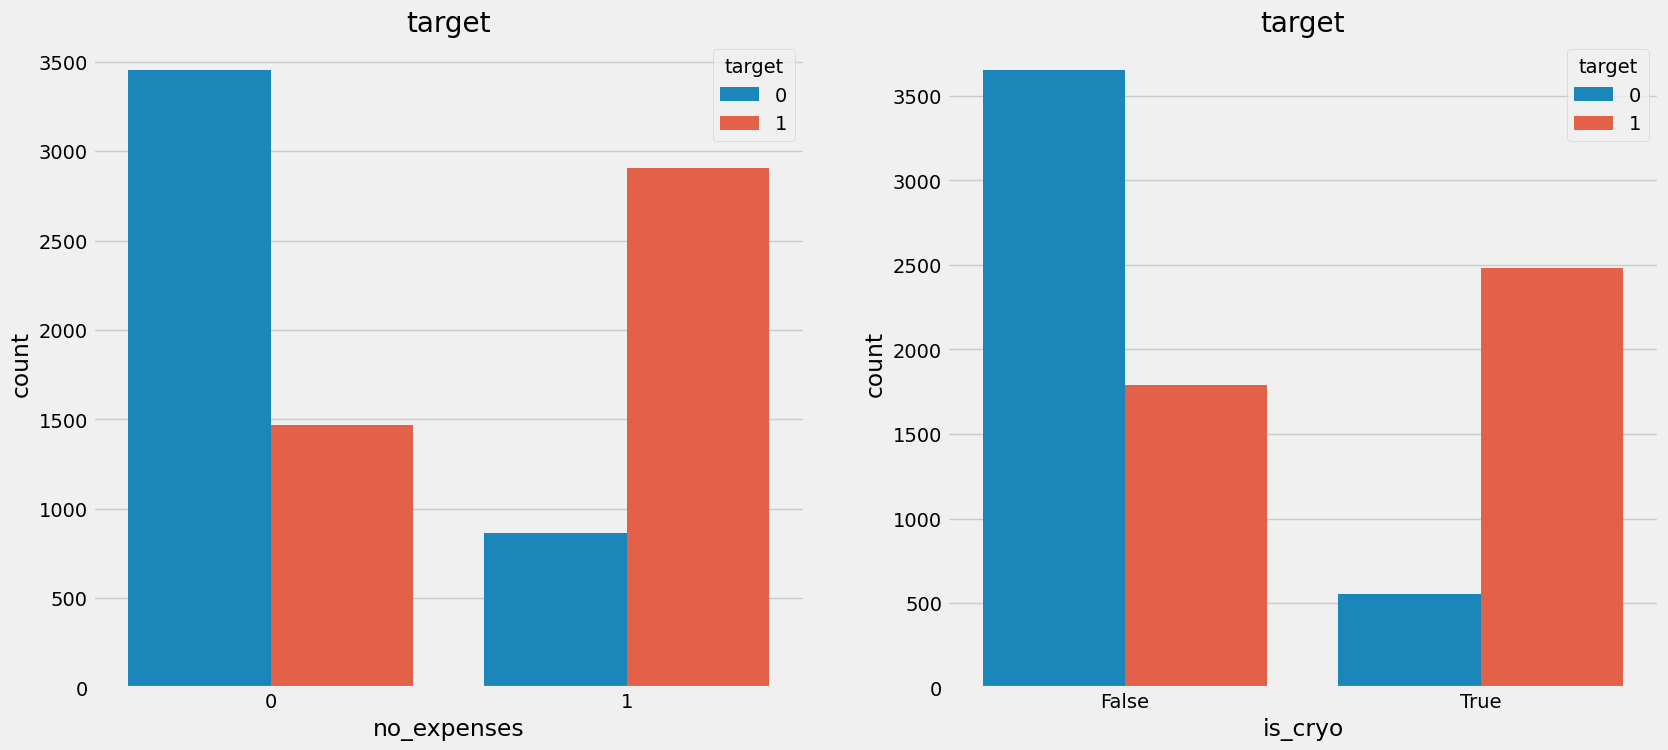

In [52]:
# Теоретически, можно повыкидывать столбцы про криосон и столбцы с расходами, оставив no_expences
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.countplot(x=df['no_expenses'], hue=df['target'], ax=ax[0])
ax[0].set_title('target')
sns.countplot(x=df['is_cryo'], hue=df['target'], ax=ax[1])
ax[1].set_title('target')
plt.show()

In [10]:
# определим номер комнаты, палубу и сторону из номера каюты
df["deck"], df["num"], df['side'] = zip(*df.apply(resolve_cab, axis=1))
df_sample["deck"], df_sample["num"], df_sample['side'] = zip(*df_sample.apply(resolve_cab, axis=1))

In [53]:
# Исследование сколько кают занимают члены одной семьи
# df[df['famount'] == 2].groupby(['deck','side', 'num', 'family', 'famount'])['target'].agg(['sum'])
# df[df['famount'] == 7].groupby(['family', 'famount'])['cab'].agg(['nunique', 'sum'])
# df_temp = df[df['famount'] >0].groupby(['family'])['side'].agg(['nunique', 'count'])
# df_temp['nunique'].max()

# Резюме у семьи если каюты разные то всегда на одной стороне. Палубы могут быть соседними

Port vs Star sides


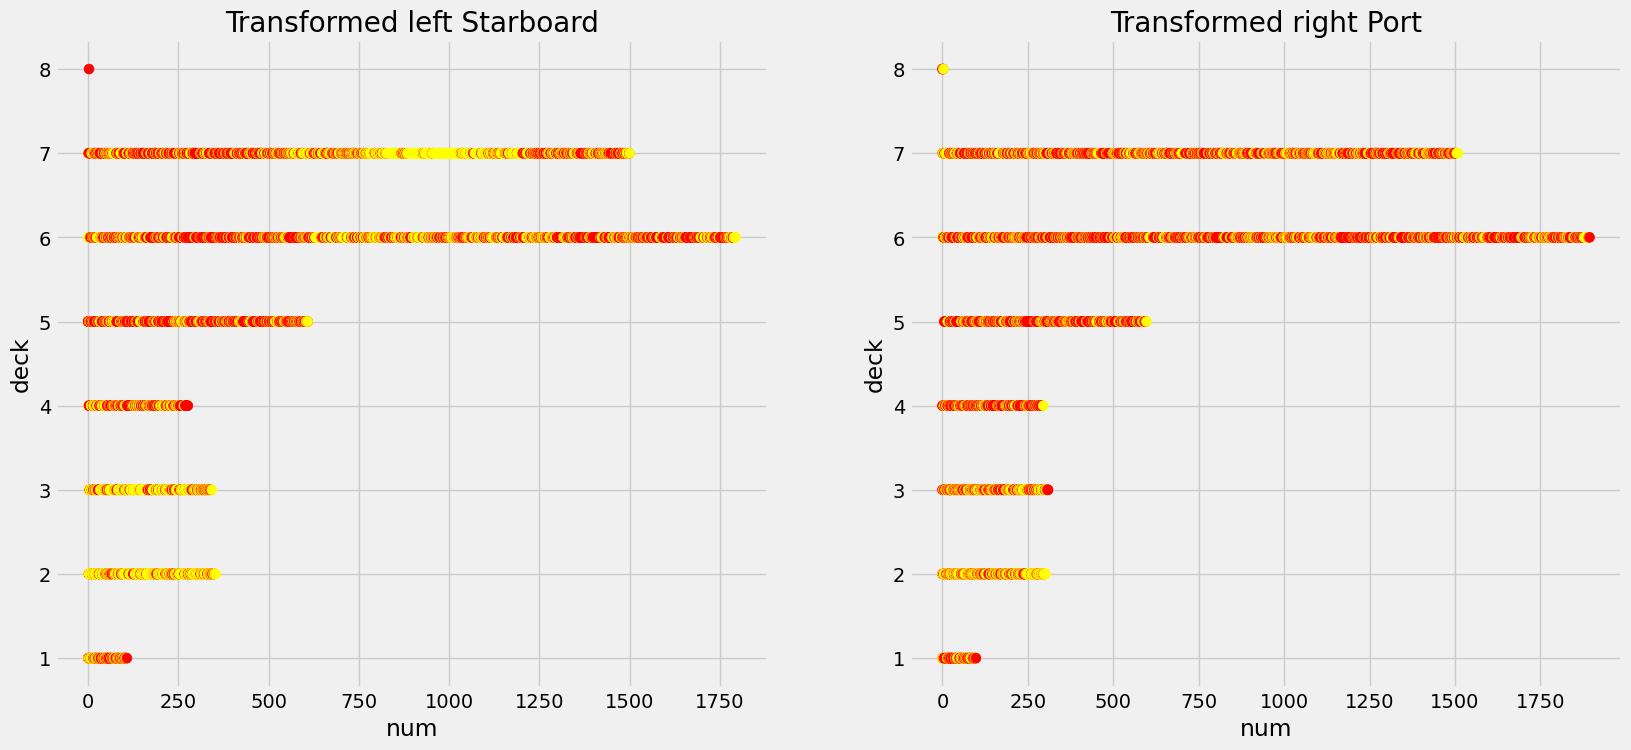

In [62]:
# Картинка из которой понятно, что палуба и сторона и расположение каюты имеют значение
left = df[df['side'] == 1]
right = df[df['side'] == 0]
f,ax=plt.subplots(1,2,figsize=(18,8))
# plt.scatter(myImputer_data['curv_excess'], myImputer_data['curv_std'], 
#             c=myImputer_data['target'], s=50, cmap='autumn')
ax[0].scatter(left['num'], left['deck'], 
            c=left['target'], s=50, cmap='autumn')
ax[0].set_title('Transformed left Starboard')
ax[0].set_xlabel('num')
ax[0].set_ylabel('deck')
ax[1].scatter(right['num'], right['deck'], 
            c=right['target'], s=50, cmap='autumn')
ax[1].set_title('Transformed right Port')
ax[1].set_xlabel('num')
ax[1].set_ylabel('deck')
print('Port vs Star sides')

In [11]:
# по сопоставлению порта отплытия и занимаемых палуб. Табличка в экселе записана
df['home'] = df.loc[:, ['home', 'deck']].apply(lambda x: 'Earth' if x[1] == 7 else x[0], axis=1)
df['home'] = df.loc[:, ['home', 'deck']].apply(lambda x: 'Europa' if x[1] in (1,2,3,8) else x[0], axis=1)

df_sample['home'] = df_sample.loc[:, ['home', 'deck']].apply(lambda x: 'Earth' if x[1] == 7 else x[0], axis=1)
df_sample['home'] = df_sample.loc[:, ['home', 'deck']].apply(lambda x: 'Europa' if x[1] in (1,2,3,8) else x[0], axis=1)

In [12]:
df.isnull().sum()

id               0
home            63
is_cryo        217
cab             99
dest           103
age            179
vip            203
has_room       111
has_food       110
has_shop       104
has_spa        113
has_vrd        119
name           200
target           0
family           0
family_size      0
no_expenses      0
deck            99
num             99
side            99
dtype: int64

In [13]:
df_sample.isnull().sum()

id               0
home            51
is_cryo         93
cab            100
dest            92
age             91
vip             93
has_room        56
has_food        67
has_shop        61
has_spa         57
has_vrd         50
name            94
family           0
family_size      0
no_expenses      0
deck           100
num            100
side           100
dtype: int64

In [14]:
# надо что то делать с каютами палубами и сторонами
num_dict_pside = {}
num_dict_sside = {}
print('Deck, Side, Num of free room')
for i in range(1, 9):
    pside = df[(df['deck'] == i)&(df['side']==1)]['num'].max()
    sside = df[(df['deck'] == i)&(df['side']==0)]['num'].max()
    cab_count_pside = len(df[(df['deck'] == i)&(df['side']==1)]['num'].unique())
    cab_count_sside = len(df[(df['deck'] == i)&(df['side']==0)]['num'].unique())
    print(i,pside, pside - cab_count_pside, '|', sside, sside - cab_count_sside)
    num_dict_pside[i]=int(pside)
    num_dict_sside[i]=int(sside)

print('Сколько комнат на каждой стороне каждой палубы')
print(num_dict_pside, '\n', num_dict_sside)  

Deck, Side, Num of free room
1 107.0 25.0 | 98.0 31.0
2 353.0 110.0 | 301.0 95.0
3 342.0 106.0 | 309.0 109.0
4 276.0 100.0 | 295.0 98.0
5 608.0 218.0 | 597.0 211.0
6 1793.0 636.0 | 1894.0 676.0
7 1500.0 510.0 | 1508.0 501.0
8 2.0 1.0 | 3.0 -1.0
Сколько комнат на каждой стороне каждой палубы
{1: 107, 2: 353, 3: 342, 4: 276, 5: 608, 6: 1793, 7: 1500, 8: 2} 
 {1: 98, 2: 301, 3: 309, 4: 295, 5: 597, 6: 1894, 7: 1508, 8: 3}


In [15]:
import random 

def set_random_side():
    return 1 if random.uniform(-1, 1)>0 else -1

def set_random_deck():
    return int(random.uniform(1, 8.1))

def set_random_cab_num(deck, side):
    if side == 1:
        return int(random.uniform(1,  num_dict_pside.get(deck)))
    else:
        return int(random.uniform(1,  num_dict_sside.get(deck)))

In [16]:
df['side'] = df['side'].apply(lambda x:  set_random_side() if pd.isna(x) else x)
df['deck'] = df['deck'].apply(lambda x:  set_random_deck() if pd.isna(x) else x)
df['num'] = df.loc[:, ['num', 'deck', 'side']].apply(lambda x:  set_random_cab_num(*x[1:]) if pd.isna(x[0]) else x[0], axis=1)

In [17]:
df_sample['side'] = df_sample['side'].apply(lambda x:  set_random_side() if pd.isna(x) else x)
df_sample['deck'] = df_sample['deck'].apply(lambda x:  set_random_deck() if pd.isna(x) else x)
df_sample['num'] = df_sample.loc[:, ['num', 'deck', 'side']].apply(lambda x:  set_random_cab_num(*x[1:]) if pd.isna(x[0]) else x[0], axis=1)

In [18]:
df.isnull().sum()

id               0
home            63
is_cryo        217
cab             99
dest           103
age            179
vip            203
has_room       111
has_food       110
has_shop       104
has_spa        113
has_vrd        119
name           200
target           0
family           0
family_size      0
no_expenses      0
deck             0
num              0
side             0
dtype: int64

In [19]:
df['total'] = df.apply(lambda x: set_total(x), axis=1)

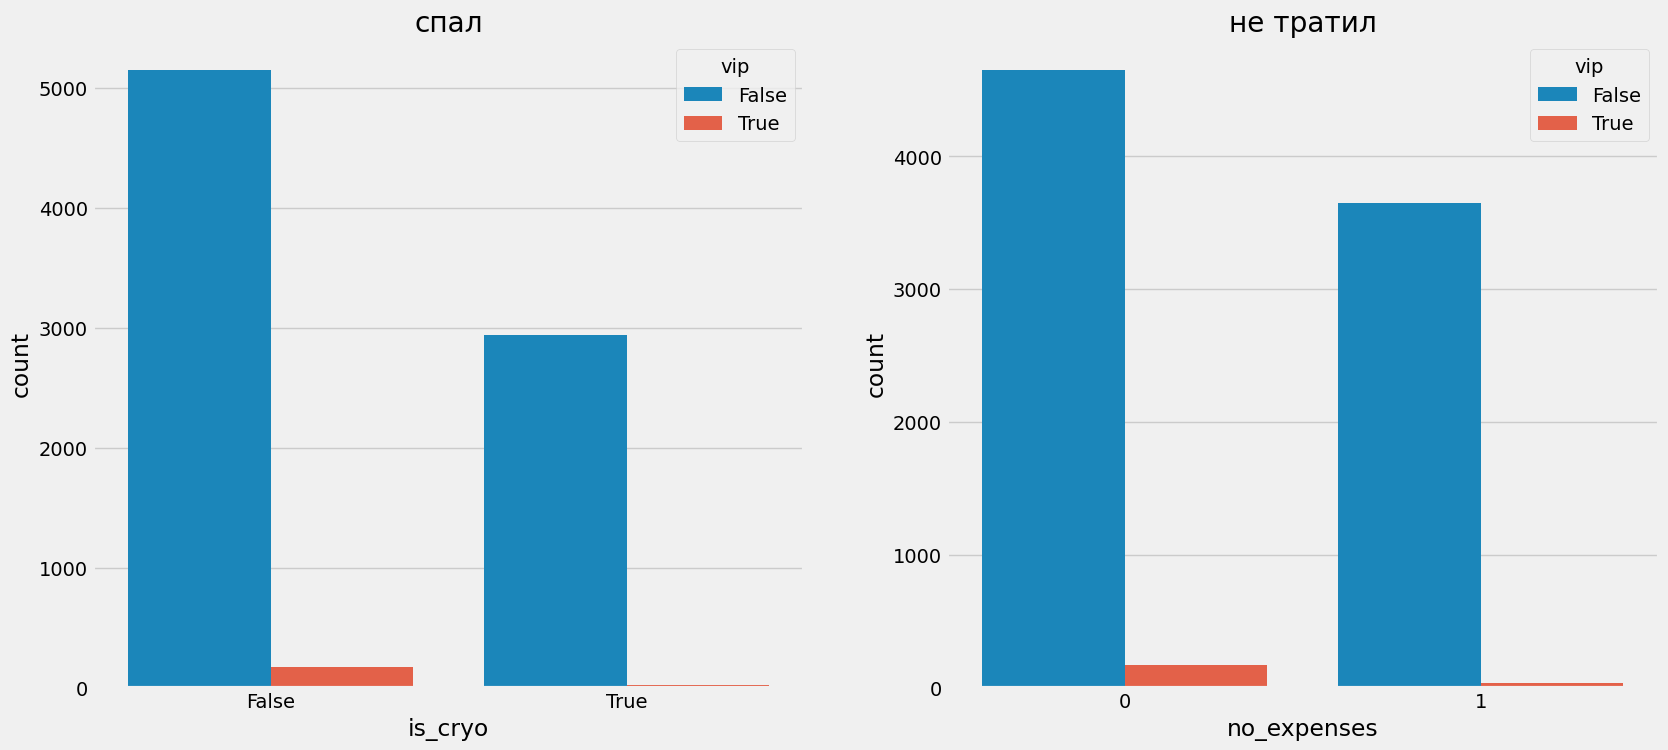

In [21]:
# 
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.countplot(x=df['is_cryo'], hue=df['vip'], ax=ax[0])
ax[0].set_title('спал')
sns.countplot(x=df['no_expenses'], hue=df['vip'], ax=ax[1])
ax[1].set_title('не тратил')
plt.show()

In [20]:
df[(df['is_cryo'])&(df['vip'])].shape[0]

21

In [21]:
df[pd.notna(df['vip'])&(df['vip'])].shape[0]

199

In [22]:
# как заполнить вип. Если спал то не вип, если не спал - наоборот. Большинство випов не спало.  
def set_vip(sleep):
    
    if not sleep:
        return True
    else:
        return False

df['vip'] = df.loc[:,['vip', 'is_cryo']].apply(lambda x: set_vip(x[1]) if pd.isna(x[0]) else x[0], axis=1)
df_sample['vip'] = df_sample.loc[:,['vip', 'is_cryo']].apply(lambda x: set_vip(x[1]) if pd.isna(x[0]) else x[0], axis=1)


In [23]:
df['age'].median()

27.0

In [24]:
df['age'] = df['age'].fillna(27)
df_sample['age'] = df_sample['age'].fillna(27)

In [25]:

df['home'] = df['home'].fillna('from_nan')
df['dest'] = df['dest'].fillna('to_nan')
df.isnull().sum()

id               0
home             0
is_cryo        217
cab             99
dest             0
age              0
vip              0
has_room       111
has_food       110
has_shop       104
has_spa        113
has_vrd        119
name           200
target           0
family           0
family_size      0
no_expenses      0
deck             0
num              0
side             0
total            0
dtype: int64

In [26]:
def create_home_dest_features(data):
    
    df_home = pd.get_dummies(data['home'])
    data = pd.merge(data, df_home, left_index=True, right_index=True)
    df_dest = pd.get_dummies(data['dest'])
    data = pd.merge(data, df_dest, left_index=True, right_index=True)

    home_dest_cols = {'Earth': 'from_ea', 'Europa':'from_eu', 'Mars':'from_ma', '55 Cancri e': 'to_can',
       'PSO J318.5-22': 'to_pso', 'TRAPPIST-1e': 'to_trap'}
    data = data.rename(columns=home_dest_cols)
    return data

In [27]:
df = create_home_dest_features(df)
df_sample = create_home_dest_features(df_sample)

In [28]:
df.columns

Index(['id', 'home', 'is_cryo', 'cab', 'dest', 'age', 'vip', 'has_room',
       'has_food', 'has_shop', 'has_spa', 'has_vrd', 'name', 'target',
       'family', 'family_size', 'no_expenses', 'deck', 'num', 'side', 'total',
       'from_ea', 'from_eu', 'from_ma', 'from_nan', 'to_can', 'to_pso',
       'to_trap', 'to_nan'],
      dtype='object')

In [29]:
work_features = [ 'age', 'vip', 'family_size', 'no_expenses', 'deck', 'num', 'side', 'total',
       'from_ea', 'from_eu', 'from_ma', 'from_nan', 'to_can', 'to_pso',
       'to_trap', 'to_nan']
target = 'target'

In [30]:
df_ = df.loc[:, work_features].copy(deep=True)
df_= df_.astype(np.int32)
df_.dtypes

age            int32
vip            int32
family_size    int32
no_expenses    int32
deck           int32
num            int32
side           int32
total          int32
from_ea        int32
from_eu        int32
from_ma        int32
from_nan       int32
to_can         int32
to_pso         int32
to_trap        int32
to_nan         int32
dtype: object

In [31]:
df_.isnull().sum()

age            0
vip            0
family_size    0
no_expenses    0
deck           0
num            0
side           0
total          0
from_ea        0
from_eu        0
from_ma        0
from_nan       0
to_can         0
to_pso         0
to_trap        0
to_nan         0
dtype: int64

In [32]:

from sklearn.model_selection import train_test_split
X = df_
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X.columns

Index(['age', 'vip', 'family_size', 'no_expenses', 'deck', 'num', 'side',
       'total', 'from_ea', 'from_eu', 'from_ma', 'from_nan', 'to_can',
       'to_pso', 'to_trap', 'to_nan'],
      dtype='object')

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [35]:
model = SVC()
param_grid = {'kernel': ['linear'], 
              'C': [1, 10],
              'gamma': [0.0001, 0.001]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(X_train, y_train)

Wall time: 11min 7s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [0.0001, 0.001],
                         'kernel': ['linear']})

In [36]:
grid.best_params_

{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}

In [37]:
model = grid.best_estimator_
y_predicted = model.predict(X_test)

[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Test Actual vs Predicted')]

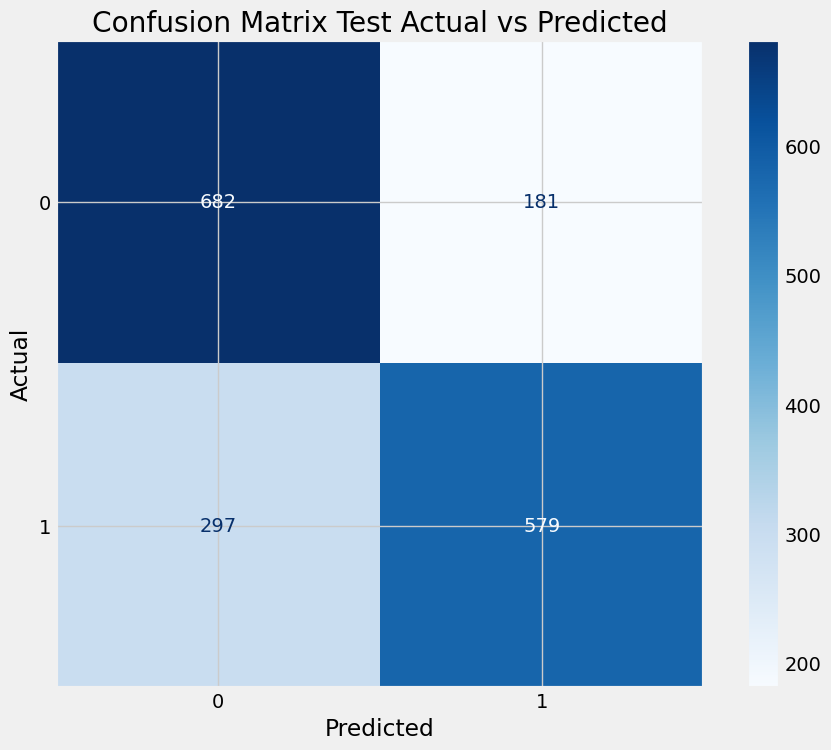

In [38]:
from sklearn import metrics
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(model, X_test, y_test, ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix Test Actual vs Predicted')

[Text(0.5, 0, 'Train Predicted'),
 Text(0, 0.5, 'Train Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

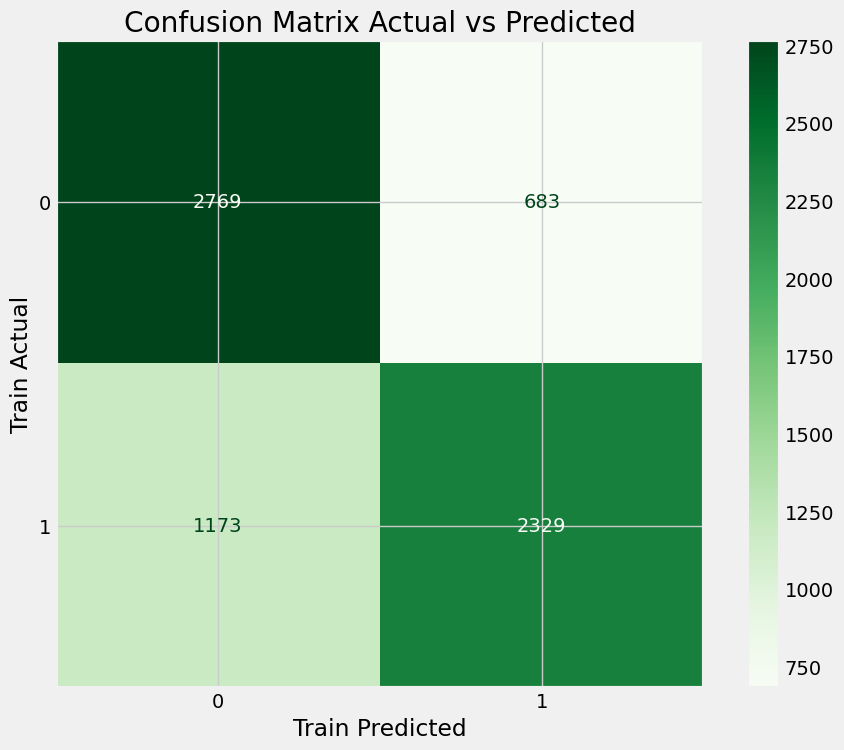

In [39]:
fig, ax = plt.subplots(figsize=(10,8))
metrics.plot_confusion_matrix(model, X_train, y_train, ax=ax, cmap=plt.cm.Greens)
ax.set(xlabel='Train Predicted', ylabel='Train Actual', title='Confusion Matrix Actual vs Predicted')

In [40]:
from sklearn. metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       863
           1       0.76      0.66      0.71       876

    accuracy                           0.73      1739
   macro avg       0.73      0.73      0.72      1739
weighted avg       0.73      0.73      0.72      1739

